# No event types continuously-observed process

Estimation of betas:

1. grid search GS
2. direct likelihood maximization DLM
3. two-stage regression TSR
4. expectation-maximization EM

In [27]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from estimate_no_event_types import *
from simulate_gillespie import gillespie_sim_complete

from scipy.optimize import minimize
from scipy.optimize import least_squares

## Setup

In [28]:
N = 100 # TODO: increase
I0 = 10
time_max = 10.0
mu_true = 1.0

# true parameters for data generation 
# Case 1: "Balanced"
beta1_true, beta2_true = (3.7, 1.0)

# convert SCALED true betas to ORIGINAL per-interaction true betas
beta1_orig_true = beta1_true / N
beta2_orig_true = beta2_true / (N**2)

## Generate data

In [29]:
nsims = 1 # NOTE: single run
# TODO: try with 10, or even 100 runs

X_sims = []
for _ in range(nsims):
    X_t = gillespie_sim_complete(N, beta1_orig_true, beta2_orig_true, mu_true, I0, time_max)
    X_sims.append(X_t)

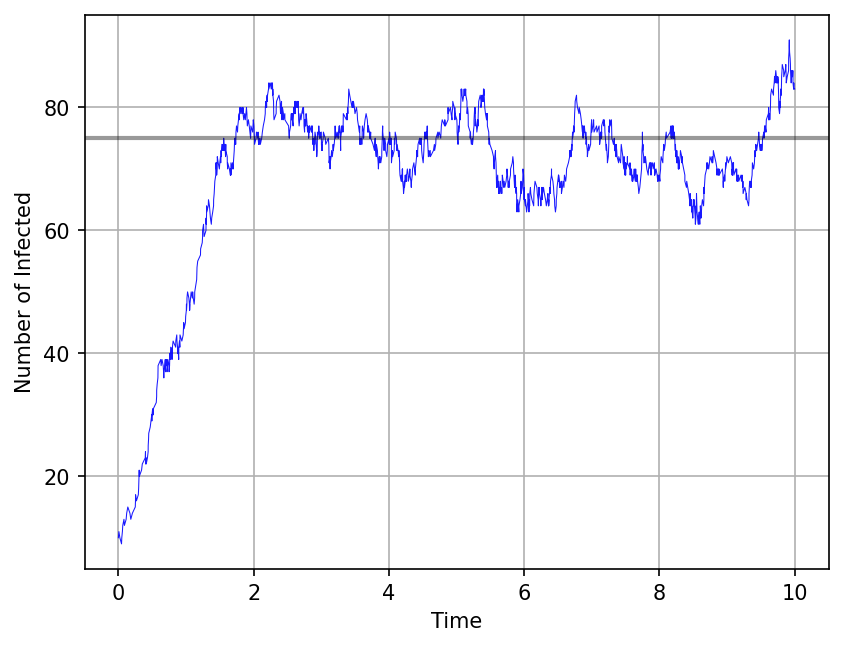

In [30]:
fig = plt.figure(dpi=150)
ax  = plt.subplot()
ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)
plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.show()

## Sufficient (aggregated) statistics

- $B_k$: Total number of observed births from state $k$.
- $D_k$: Total number of observed deaths from state $k$.
- $T_k$: Total time spent in state $k$.

In [31]:
stats = get_sufficient_stats(X_t, N)

In [32]:
print(f"Total time spent in states:")
visited_k = np.where(stats['T_k'] > 0)[0]
for k in visited_k[:5]:
    print(f"  k={k}: T_k = {stats['T_k'][k]:.4f}")

print(f"\nTotal births from states:")
birth_k = np.where(stats['B_k'] > 0)[0]
for k in birth_k[:5]:
    print(f"  k={k}: B_k = {int(stats['B_k'][k])}")

print(f"\nTotal deaths from states:")
death_k = np.where(stats['D_k'] > 0)[0]
for k in death_k[:5]:
    print(f"  k={k}: D_k = {int(stats['D_k'][k])}")

Total time spent in states:
  k=9: T_k = 0.0038
  k=10: T_k = 0.0415
  k=11: T_k = 0.0198
  k=12: T_k = 0.0434
  k=13: T_k = 0.0384

Total births from states:
  k=9: B_k = 1
  k=10: B_k = 2
  k=11: B_k = 1
  k=12: B_k = 2
  k=13: B_k = 2

Total deaths from states:
  k=10: D_k = 1
  k=11: D_k = 1
  k=13: D_k = 1
  k=14: D_k = 1
  k=15: D_k = 1


## Likelihood 

$$
\ell(\beta_1, \beta_2) = \sum_{k = 0}^{N} \left[ B_k \ln(\lambda_k(\beta_1, \beta_2)) + D_k \ln(\mu_k(\mu)) - (\lambda_k(\beta_1, \beta_2) + \mu_k(\mu)) T_k \right]
$$

Create grid and plot the likelihood surface:

## Plotting

In [33]:
b1_range = (0, 6.0, 100)
b2_range = (0, 12.0, 100)
surface_data = compute_likelihood_surface(b1_range, b2_range, stats, N, mu_true)

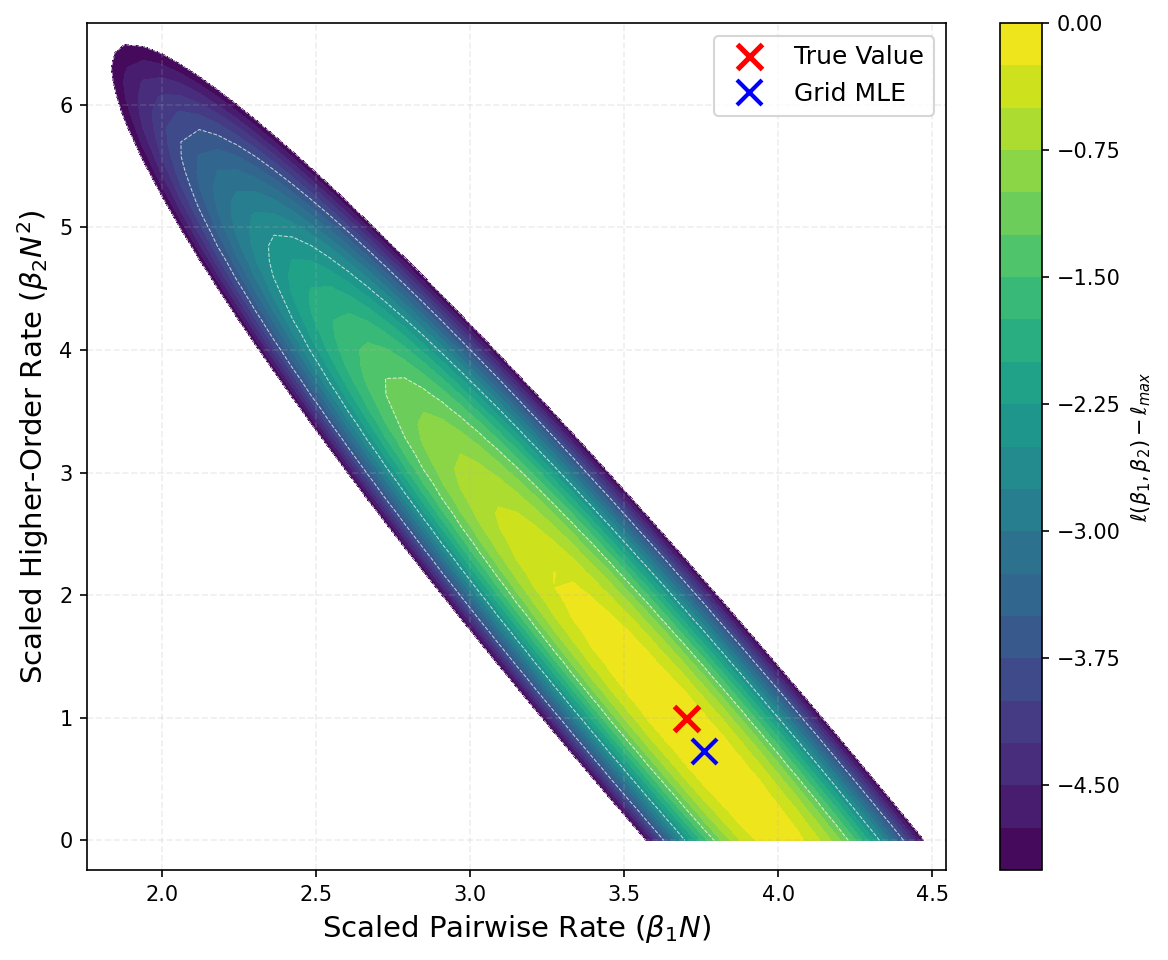

In [34]:
plot_zoomed_likelihood(surface_data, (beta1_true, beta2_true), threshold=-5.0)

In [35]:
beta1_true, beta2_true

(3.7, 1.0)

In [36]:
estimate_em(stats, N, mu_true, [0.01 / N, 0.01 / (N**2)])

(np.float64(3.724639459811981), np.float64(0.8370675849590514))

In [37]:
estimate_em(stats, N, mu_true, [1 / N, 1 / (N**2)])

(np.float64(3.724639459811981), np.float64(0.8370675849590514))

In [38]:
grid_search(stats, N, mu_true)

(np.float64(3.7979797979797985), np.float64(0.6060606060606061))

In [39]:
estimate_dlm(stats, N, [0.01 / N, 0.01 / (N**2)])

(np.float64(3.7253806656231263), np.float64(0.8348486408763849))

In [40]:
estimate_dlm(stats, N, [1 / N, 1 / (N**2)])

(np.float64(3.7253878226135955), np.float64(0.834821532883526))

In [41]:
estimate_dlm(stats, N, [1, 1])

(np.float64(3.725430485103143), np.float64(0.8347115411432833))

In [42]:
estimate_tsr(stats, N, [1, 1])

(np.float64(3.613169317068274), np.float64(1.079831014274698))

In [43]:
estimate_tsr(stats, N, [1 / N, 1 / (N**2)])

(np.float64(3.6131693153164726), np.float64(1.079831019408677))

In [44]:
estimate_tsr(stats, N, [0.01 / N, 0.01 / (N**2)])

(np.float64(3.613169255053761), np.float64(1.0798312008677051))

## DLM

## TSR

1. stage: estimate birth rates $\lambda_k$ for each state $k$ visited

2. stage: fit $\beta_1 f_1(k) + \beta_2 f_2(k)$ to $(k, \lambda_k)$ points

NOTE: Needs to be weighted least-squares:

- the variance around each point is not the same

- the number of births $B_k$ from state $k$ is a Poisson r.v. with mean $\lambda_k T_k$

- the variance is also $\lambda_k T_k$

Approximate weights as $T_k$ since we do not know the true $\lambda_k$

In [45]:
# initial guess could be something small
x0 = [0.01 / N, 0.01 / (N**2)]

# EM - derived algorithm